### Title: Box Jenkins Methods

Author: Chris Hyland／Yiran Jing

Date: 10-10-2018

##### Summary

- Fitted an ARMA(p,q) model on the data, where p is from 0-2, q is from 0-2. Additionally, tried fitting an exponentional smoothing model.


- ARMA(1,0,0) is the best choice based on the overall trade-off by AIC and MAPE. However, we are still underperforming the baseline model. These notebooks do not consider any exogenous regressors and will be explored further in another notebook.

In [3]:
from collections import Counter
import pandas as pd
import csv
import pprint
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from collections import defaultdict
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas import Series
from matplotlib import pyplot
#from time_series import ts_plot,ts_plot2,ts_plot3,acf_pacf_plot,hist,modify_time_format,epoch_seconds_to_timestamp

#from time_series import pd_read_obs_csv # function used for read SA weather obs
import statsmodels.api as sm
import seaborn as sns
import datetime
import glob, os

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
# product_of_interest = [1111087398, 1111087395, 1111087396]
train_data = pd.read_csv('../../intellify_data/Train_data.csv')
val_data = pd.read_csv('../../intellify_data/Val_data.csv')

train_data = train_data.set_index("Date")
val_data = val_data.set_index("Date")

Please refer to Models_1_VAR notebook to view the data wrangling and earlier analysis. We are only working with 3 products of interest. 

They are pizza within the top 5 high correlation

## Box Jenkin Models

In [18]:
from statsmodels.tsa.arima_model import ARIMA

## AR(1) Models just to try things out initially.

When forecasting, "under forecasting" demand is considered worse than "over forecasting" demand.

We use the MAPE, as it puts a heavier penalty on negative errors (so under forecasting) relative to positive errors

In [19]:
"""
Checking results of AR(1) prediction.
"""

products = ["Prod_one", "Prod_two", "Prod_three"]

results = {}
# Loop over a forecast product
for prod in products:
    # Compute metric for each product.
    diff = []
    train_data[prod] = train_data[prod].astype('float64')
    # Fit and predict AR(1) model.
    ar_mod = ARIMA(train_data[prod], order=(1,0,0)).fit()
    var_pred = ar_mod.predict(start=val_data.index[0], end=val_data.index[-1])
    
    for time in range(0, len(val_data[prod])):
        # CHANGE THIS LINE TO CHANGE ERROR METRIC.
        diff.append(100*(abs(var_pred[time] - val_data[prod].iloc[time])/val_data[prod].iloc[time]))

    # Add the result to dictionary.
    results.update({prod: sum(diff)/len(diff)})

In [20]:
pd.DataFrame(list(results.items()), columns=['Product', 'MAPE'])

,Product,MAPE
0,Prod_one,43.068727
1,Prod_two,48.742628
2,Prod_three,50.264223


On average, the AR(1) model is off by roughly 45%. Terrible performance, but it is to be expected.

## P and Q selection
The data is stationary, refer to Models_1_VAR notebook to view this.

We now try a selection selection processes to decide the number of lags for the AR(p) and MA(q) model.

### Method 1: Visualization selection  based on ACF/PACF.

In [22]:
def data_time(data,x):
    """
    Assist in wrangling the dataset for the draw_acf_pacf method.
    """
    y_=data.loc[:,['Date',x]]
    y_.set_index('Date',inplace=True)
    y_.index = pd.to_datetime(y_.index)
    return y_


def draw_acf_pacf(check, data):
    """
    Run ACF/PACF plot on each variable and check.
    """
    for prob in check:
        print("Product {} ".format(prob))
        fig, ax = plt.subplots(1,2, figsize=(12,3))
        y = data_time(data,prob)
        sm.graphics.tsa.plot_acf(y, lags=50, ax=ax[0])
        sm.graphics.tsa.plot_pacf(y, lags=50, ax=ax[1])
        sns.despine()
        fig.tight_layout()
        plt.show()

Product Prod_one 


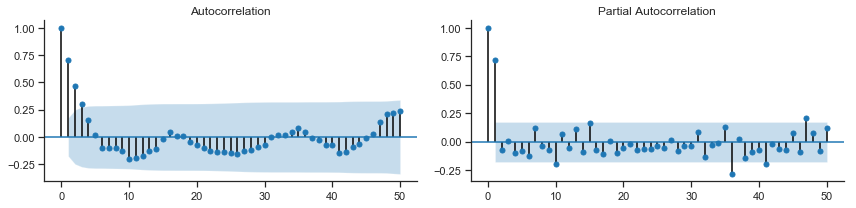

Product Prod_two 


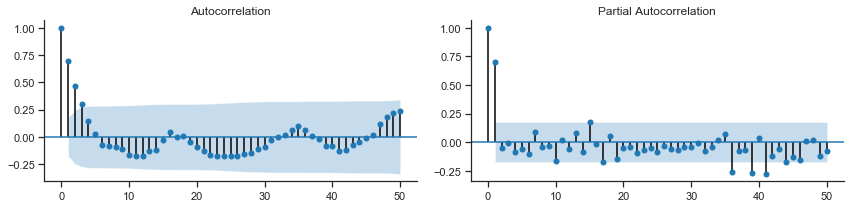

Product Prod_three 


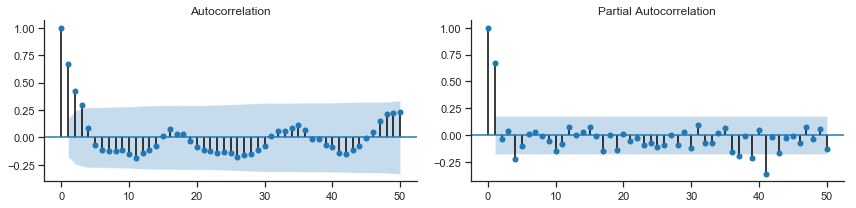

In [23]:
products = ["Prod_one", "Prod_two", "Prod_three"]
draw_acf_pacf(products, train_data)

**Analysis of graphs for product 1-3 for the AR(p) model**

From the charts, they suggest that the number of lags p should be around 3-4. The rationale is that for the autocorrelation plots, the autocorrelation decrease exponentionally after the 4 period mark. However, for the partial autocorrelation, it cuts off to zero after lag 1.

Regardless, it appears that the AR(1) only is enough, but we still check other possible combinations.

### Method 2: Information Criteria selection based on the AIC for an ARMA(P,Q) Model.


#### Model selection range

- The parameter space for p is the interval (0,2) whilst for q, it is (0,2).

#### Findings of this section:
##### Based on AIC selection

- AR(1) is suggested to be the most appropriate model.

##### Based on MAPE

- AR(1) is suggested to be the most appropriate model.


In [25]:
"""
Here, the benchMark is the AR(1) model.
"""
y = data_time(train_data,'Prod_one')
arma_benchmark=sm.tsa.statespace.SARIMAX(y, order=(1, 0, 0)).fit()

In [26]:
def aic_selection(data, p_lag, q_lag): 
    '''
    Forward selection based on the AIC.
    
    Parameters
    --------
    data: series
        The data to test for.
    p_lag: int scalar
        Maximum number of lags to test for AR.
    q_lag: int scalar
        Maximum number of lags to test for MA.
    
    Returns
    --------
    results: tuple
        Tuple containing optimal p,q, and AIC score.
    '''
    best_score = np.inf
    opt_p, opt_q = 0, 0

    range_p, range_q= range(p_lag), range(q_lag)

    # Iterate through and fit different lags.
    for p in opt_p:
        for q in opt_q:
            try:
                model=sm.tsa.statespace.SARIMAX(y,  order=(i, 0, k)).fit()
                score=model.aic
                if (score<best_score):
                    best_score = model.aic
                    opt_p, opt_q = p, q
            except ValueError:
                pass

    return (opt_p, opt_q, best_score)

In [ ]:
'''
Select best ARMA model based on AIC, MAPE for each product
'''
products = ["Prod_one", "Prod_two", "Prod_three"]
results = {}

for prod in products:
    y = data_time(train_data,prod)
    opt_p, opt_q, best_score = aic_selection(y, 3, 3)
    
    results.update({prod: [opt_p, opt_q, best_score.round(2)]})

In [27]:
'''
Select best ARMA model based on AIC, MAPE for each product
'''
products = ["Prod_one", "Prod_two", "Prod_three"]
results = {}
for prod in products:
    y = data_time(train_data,prod)
    arma_benchmark=sm.tsa.statespace.SARIMAX(y, order=(1, 0, 0)).fit() 
    p1, q1, best_score1 = aic_selection(arma_benchmark,1, 0)
    results.update({prod: [p1, q1,best_score1.round(2)]})

The best lags to use for each product.

In [48]:
# Just some data formatting wrangling for next block.

final_data = []
for i in range(len(results.items())):
    # Loop through product.
    temp = []
    temp.append(list(results.items())[i][0])
    for score in list(results.items())[i][1]:
        # Extract p,q, and AIC.
        temp.append(score)
    final_data.append(temp)

In [47]:
pd.DataFrame(final_data, columns=['Product','Optimal P','Optimal Q','AIC'])

,Product,Optimal P,Optimal Q,AIC
0,Prod_one,1,0,1912.13
1,Prod_two,1,0,1840.05
2,Prod_three,1,2,1856.30


Hence, it appears the consensus is generally P=1 and Q=0.

## Exponential smoothing

This model can be written as ARIMA(0,1,1).

### Summary of this section.
If our model selection is based on the AIC, ES has slighly smaller AIC than ARMA(1, 0, 0) for three products, but unfortunately it has a bigger MAPE than AR(1). 

Resultantly, the AR(1) is still a better choice overall.

In [49]:
'''
Compare ES model with ARMA result based on AIC for each product
'''
products = ["Prod_one", "Prod_two", "Prod_three"]
results = {}
for prod in products:
    y = data_time(train_data,prod)
    arma_benchmark=sm.tsa.statespace.SARIMAX(y, order=(0, 1, 1)).fit() 
    p1, q1, best_score1 = aic_selection(arma_benchmark, 0, 1)
    
    results.update({prod: [p1, q1,best_score1.round(2)]})

In [52]:
"""
Checking results of Exponential smoothing prediction.
"""

products = ["Prod_one", "Prod_two", "Prod_three"]

results = {}
# Loop over a forecast product
for prod in products:
    # Compute metric for each product.
    diff = []
    train_data[prod] = train_data[prod].astype('float64')
    # Fit and predict AR(1) model.
    ar_mod = ARIMA(train_data[prod], order=(0,1,1)).fit()
    var_pred = ar_mod.predict(start=val_data.index[0], end=val_data.index[-1])
    
    for time in range(0, len(val_data[prod])):
        # CHANGE THIS LINE TO CHANGE ERROR METRIC.
        diff.append(100*(abs(var_pred[time] - val_data[prod].iloc[time])/val_data[prod].iloc[time]))

    # Add the result to dictionary.
    results.update({prod: sum(diff)/len(diff)}) 

In [53]:
pd.DataFrame(list(results.items()), columns=['Product', 'MAPE'])

,Product,MAPE
0,Prod_one,101.255797
1,Prod_two,101.088261
2,Prod_three,101.252627


The MAPE here is extremely high. Definitely an extremely poor performance from the exponential model.